# Problema 9.5

Seleccionar la ganancia de un controlador proporcional utilizando el criterio de la razón de disminución 1/4. El proceso a controlar es:

$$G_p(s) = \frac{10}{(s+2)(2s+1)}$$

Asumir que $G_m(s) = G_f(s) = 1$. Realizar también la sintonía utilizando el criterio del ISE mínimo con un cambio en la consigna en escalón unidad. En ambos casos se debe satisfacer la condición de que $100 \ge K_c \ge 0.1$. Comparar las sintonías y explicar las diferencias entre ellas.

---

**Solución**


**Razón de disminución 1/4**

El bucle de control propuesto por el enunciado del problema es:

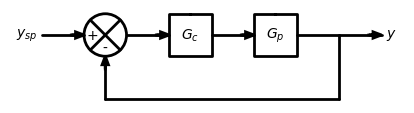

In [1]:
using PyCall, LaTeXStrings

schemdraw = pyimport("schemdraw")
dsp = pyimport("schemdraw.dsp")

d = schemdraw.Drawing(unit=1, fontsize=10)

d.add(dsp.Arrow().right().label(L"y_{sp}", "left"))
comp = d.add(dsp.Mixer(W="+", S="-").anchor("W"))
d.add(dsp.Arrow().right().at(comp.E))
control = d.add(dsp.Box(h=1, w=1).label(L"G_c").anchor("W"))
d.add(dsp.Arrow().right().at(control.E))
proc = d.add(dsp.Box(h=1, w=1).label(L"G_p").anchor("W"))
d.add(dsp.Line().right().at(proc.E))
dot = d.add(dsp.Dot(radius=0))
d.push()
d.add(dsp.Arrow().right().label(L"y", "right"))
d.pop()
d.add(dsp.Line().down().length(1.5))
d.add(dsp.Line().left().tox(comp.S))
d.add(dsp.Arrow().up().to(comp.S))

d.draw(show=false)

La función de transferencia que representa la dinámica de este lazo es:

$$G = \frac{K_c G_p}{1 + K_c G_p} = \frac{\frac{10 \mathrm{Kc}}{10
   \mathrm{Kc} + 2}}{\frac{2}{10 \mathrm{Kc} + 2} s^2 + \frac{5}{10
   \mathrm{Kc} + 2} s + 1}$$
   
Se trata de un sistema de segundo orden, por tanto:

$$\begin{aligned}
  & \tau^2 = \frac{2}{10 \mathrm{Kc} + 2} & \\
  & 2 \tau \zeta = \frac{5}{10 \mathrm{Kc} + 2} & \end{aligned}$$
  
Como criterio de sintonía se toma que la razón de dismunución de este lazo de control debe ser de 1/4:

$$RD = \exp \left( \frac{- 2 \pi \zeta}{\sqrt{1 - \zeta^2}} \right) =
   \frac{1}{4}$$
   
Resolviendo la ecuación anterior se obtiene:

$$\zeta = 0.2154$$

Conocido el coeficiente de amortiguamiento, ya solo queda resolver el sistema de ecuaciones anterior para obtener el valor de la ganancia proporcional:

$$K_c = 6.53$$

**Minimizar ISE**

Para obtener la sintonía óptima, aquella que minimiza la integral del error al cuadrado, del controlador se ha utilizado el programa siguiente:

In [2]:
using InverseLaplace, Optim, Trapz

# Definición de la función de transferencia del proceso
Gp(s) = 10/((s+2)*(2s+1))

# Definición de la función coste: ISE
function ISE(Kc)
    # Función de transferencia del lazo de control
    G(s) = Kc*Gp(s)/(1+Kc*Gp(s))
    
    # Respuesta del lazo de control para un cambio en la consigna
    # en forma de escalón unidad
    y(s) = G(s)*1/s
    
    # Tiempo de la simulación
    tsim = range(0.0, 2.0; length=200)
    
    # Transformada inversa de Laplace numérica para obtener y(t)
    y_t = ILT(y, 80)
    
    # Cálculo de los valores simulados de la variable controlada
    ysim = map(y_t, tsim)
    
    # Eliminación de los NaN
    for i in 1:length(ysim)
        if isnan(ysim[i])
            ysim[i] = 0.0
        end
    end
    
    # Cálculo de la integral del error al cuadrado
    ISE = trapz(tsim, (1.0 .-ysim).^2)
end

# Optimización univariante
result= optimize(ISE, 0.1, 100.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.100000, 100.000000]
 * Minimizer: 9.405378e+01
 * Minimum: 2.003785e-01
 * Iterations: 24
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 25

La ganancia proporcional obtenida es:

In [3]:
Kc_optim = Optim.minimizer(result)

94.05378407695393

El valor obtenido de la integral del error al cuadrado es:

In [4]:
Optim.minimum(result)

0.20037852173887344

Podemos compararlo con el valor obtenido con la ganancia proporcional obtenida para una razón de disminución de 1/4:

In [5]:
ISE(6.53)

0.22714454801058515

Se observa una ligera reducción en el ISE.

Finalmente podemos comparar las respuestas para las dos sintonías obtenidas:

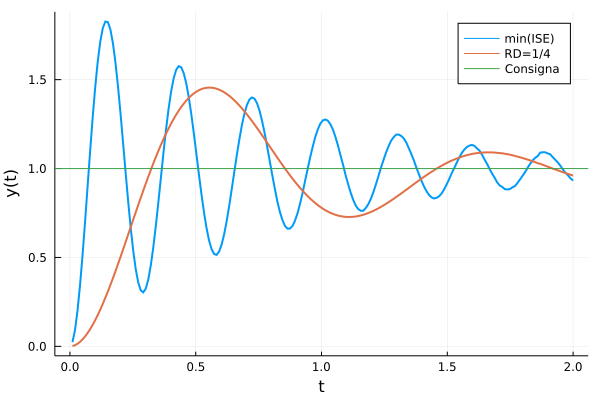

In [7]:
using Plots

function ysimul(tsim, Kc)
    G(s) = Kc*Gp(s)/(1+Kc*Gp(s))
    y(s) = G(s)*1/s
    y_t = ILT(y, 80)  
    ysim = map(y_t, tsim)
end

tsim = range(0.0, 2.0; length=200)
ysim_optim = ysimul(tsim, Kc_optim)
ysim_rd = ysimul(tsim, 6.53)


plot(tsim, ysim_optim, lw=2, label="min(ISE)", xlabel="t", ylabel="y(t)")
plot!(tsim, ysim_rd, lw=2, label="RD=1/4")
hline!([1.0], label="Consigna")